The goal is to train and visualize the outputs of a simple Deep Convolutional GAN (DCGAN) to generate realistic-looking images of clothing.

In [20]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers


In [21]:
# Set seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Create a fixed seed for visualization
seed = tf.random.normal([9, z_dim])

3a. Use the FashionMNIST training dataset (which we used in previous assignments) to train the DCGAN.
Images are grayscale and size 28 ×28.

In [22]:
# Load the data
(x_train,y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [23]:
# Reshape to include channel dimension: [batch_size, height, width, channels]
# Ensure proper normalization to [-1, 1] range
x_train = (x_train.astype(np.float32) - 127.5) / 127.5
x_test = (x_test.astype(np.float32) - 127.5) / 127.5

# Reshape to include channel dimension
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

In [24]:
# Set hyperparameters
BATCH_SIZE = 64  # As suggested in the assignment
EPOCHS = 50
z_dim = 100  # Dimensionality of the noise vector
images_generated = 9  # Number of images to display

In [25]:
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000).batch(BATCH_SIZE)

In [26]:
def build_generator():
    model = tf.keras.Sequential()

    # Dense layer: 100 → 7×7×256
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(z_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.3))

    # Reshape to 7×7×256
    model.add(layers.Reshape((7, 7, 256)))

    # First transpose conv: 256×7×7 → 128×7×7 (maintain size)
    model.add(layers.Conv2DTranspose(128, kernel_size=5, strides=1, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.3))

    # Second transpose conv: 128×7×7 → 64×14×14 (double size)
    model.add(layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.3))

    # Final transpose conv: 64×14×14 → 1×28×28 (double size)
    model.add(layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding='same', use_bias=False, activation='tanh'))

    return model

In [27]:
def build_discriminator():
    model = tf.keras.Sequential()

    # First conv: 1×28×28 → 64×14×14
    model.add(layers.Conv2D(64, kernel_size=5, strides=2, padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU(alpha=0.3))
    model.add(layers.Dropout(0.3))

    # Second conv: 64×14×14 → 128×7×7
    model.add(layers.Conv2D(128, kernel_size=5, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.3))
    model.add(layers.Dropout(0.3))

    # Flatten and map to scalar
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [28]:
# Initialize models
generator = build_generator()
discriminator = build_discriminator()


In [29]:
# Test generator
noise = tf.random.normal([1, z_dim])
generated_image = generator(noise)
print(f"Generator output shape: {generated_image.shape}")

# Test discriminator
decision = discriminator(generated_image)
print(f"Discriminator output shape: {decision.shape}")

Generator output shape: (1, 28, 28, 1)
Discriminator output shape: (1, 1)


In [30]:
# Define the loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [31]:
# Generator loss: we want the discriminator to identify fake images as real
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Discriminator loss: correctly identify real as real (1) and fake as fake (0)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


In [32]:
# Exactly as specified in the assignment
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [33]:
# Create a fixed seed for image generation to see progress
seed = tf.random.normal([images_generated, z_dim])

In [34]:
# Function to generate and display images
def generate_and_display_images(model, test_input, epoch):
    # Generate images from the seed
    predictions = model(test_input, training=False)

    # Create a 3x3 grid of generated images
    fig = plt.figure(figsize=(3, 3))

    for i in range(predictions.shape[0]):
        plt.subplot(3, 3, i+1)
        # Scale back to [0,255]
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.suptitle(f'Epoch: {epoch}')
    plt.tight_layout()
    plt.show()

In [35]:
# Training step
@tf.function
def train_step(images):
    noise = tf.random.normal([images.shape[0], z_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake images
        generated_images = generator(noise, training=True)

        # Get discriminator outputs for real and fake images
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # Calculate losses
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Calculate gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [36]:
@tf.function
def train_step(images):
    # Set proper batch size based on actual input
    batch_size = tf.shape(images)[0]
    noise = tf.random.normal([batch_size, z_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake images
        generated_images = generator(noise, training=True)

        # Get discriminator outputs
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # Calculate losses exactly as specified
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Calculate and apply gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

Starting epoch 1/50
Epoch 1, Generator Loss: 0.903348982334137, Discriminator Loss: 1.1848211288452148
Starting epoch 2/50
Epoch 2, Generator Loss: 0.8595108389854431, Discriminator Loss: 1.2637230157852173
Starting epoch 3/50
Epoch 3, Generator Loss: 0.9167836904525757, Discriminator Loss: 1.2200729846954346
Starting epoch 4/50
Epoch 4, Generator Loss: 1.013178825378418, Discriminator Loss: 1.1224013566970825
Starting epoch 5/50
Epoch 5, Generator Loss: 1.2833456993103027, Discriminator Loss: 0.9470313191413879
Starting epoch 6/50
Epoch 6, Generator Loss: 1.482519507408142, Discriminator Loss: 0.8479126691818237
Starting epoch 7/50
Epoch 7, Generator Loss: 1.4708586931228638, Discriminator Loss: 0.8633610010147095
Starting epoch 8/50
Epoch 8, Generator Loss: 1.547257900238037, Discriminator Loss: 0.8512837290763855
Starting epoch 9/50
Epoch 9, Generator Loss: 1.4836920499801636, Discriminator Loss: 0.8610470294952393
Starting epoch 10/50
Epoch 10, Generator Loss: 1.4043127298355103, D

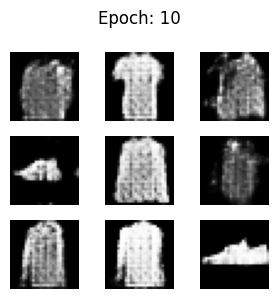

Starting epoch 11/50
Epoch 11, Generator Loss: 1.3496397733688354, Discriminator Loss: 0.9551803469657898
Starting epoch 12/50
Epoch 12, Generator Loss: 1.3757045269012451, Discriminator Loss: 0.9642916321754456
Starting epoch 13/50
Epoch 13, Generator Loss: 1.3422399759292603, Discriminator Loss: 0.9775427579879761
Starting epoch 14/50
Epoch 14, Generator Loss: 1.2485483884811401, Discriminator Loss: 1.0346304178237915
Starting epoch 15/50
Epoch 15, Generator Loss: 1.3204060792922974, Discriminator Loss: 0.9741408228874207
Starting epoch 16/50
Epoch 16, Generator Loss: 1.2794597148895264, Discriminator Loss: 1.006368637084961
Starting epoch 17/50
Epoch 17, Generator Loss: 1.1872674226760864, Discriminator Loss: 1.0653257369995117
Starting epoch 18/50
Epoch 18, Generator Loss: 1.2844620943069458, Discriminator Loss: 1.0056843757629395
Starting epoch 19/50
Epoch 19, Generator Loss: 1.2079755067825317, Discriminator Loss: 1.0620262622833252
Starting epoch 20/50
Epoch 20, Generator Loss: 

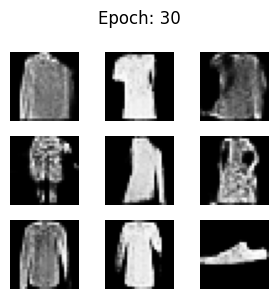

Starting epoch 31/50
Epoch 31, Generator Loss: 0.9498113393783569, Discriminator Loss: 1.2236887216567993
Starting epoch 32/50
Epoch 32, Generator Loss: 0.9459695816040039, Discriminator Loss: 1.2265100479125977
Starting epoch 33/50
Epoch 33, Generator Loss: 0.9409922957420349, Discriminator Loss: 1.2321525812149048
Starting epoch 34/50
Epoch 34, Generator Loss: 0.939769446849823, Discriminator Loss: 1.2317910194396973
Starting epoch 35/50
Epoch 35, Generator Loss: 0.9315580725669861, Discriminator Loss: 1.2303359508514404
Starting epoch 36/50
Epoch 36, Generator Loss: 0.9435891509056091, Discriminator Loss: 1.226965308189392
Starting epoch 37/50
Epoch 37, Generator Loss: 0.9389881491661072, Discriminator Loss: 1.2296046018600464
Starting epoch 38/50
Epoch 38, Generator Loss: 0.9334059357643127, Discriminator Loss: 1.2340813875198364
Starting epoch 39/50
Epoch 39, Generator Loss: 0.9191902875900269, Discriminator Loss: 1.2447024583816528
Starting epoch 40/50
Epoch 40, Generator Loss: 1

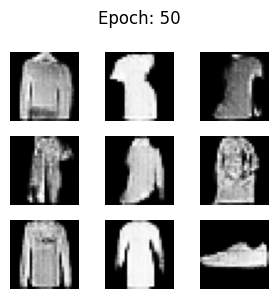

In [37]:
# Train the model
generator_losses, discriminator_losses = train(train_dataset, EPOCHS)

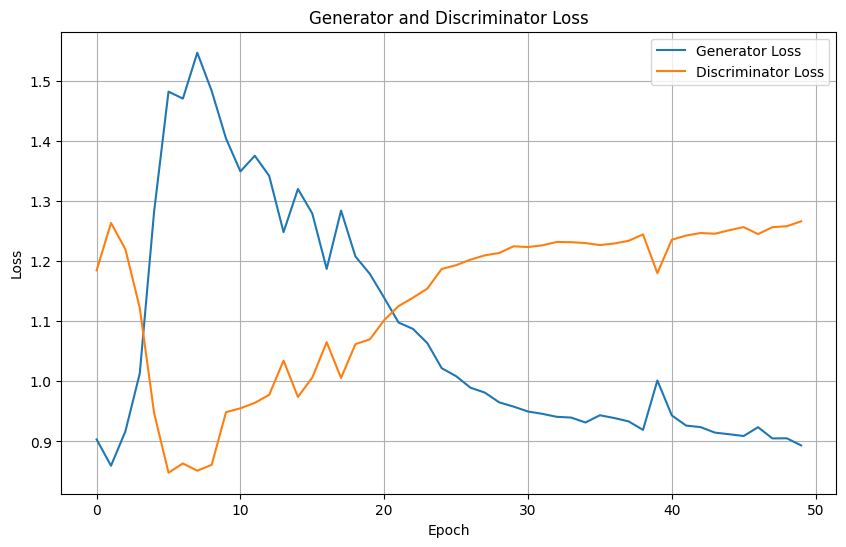

In [39]:
# Plot the loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(EPOCHS), generator_losses, label='Generator Loss')
plt.plot(range(EPOCHS), discriminator_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Generator and Discriminator Loss')
plt.show()
